In [219]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt

from keras import layers, Model, Sequential, initializers, optimizers
from keras.layers import Multiply, Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.regularizers import L1L2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, make_scorer
from keras.callbacks import LearningRateScheduler
from sklearn.linear_model import LinearRegression
from keras_tuner.tuners import RandomSearch
from sklearn.inspection import permutation_importance
from keras import backend as K

## Gated Recurrent Unit

We will use Gated Recurrent Unit (GRU) to predict stock prices. Since most RNN models suffer from short-term memory and vanishing gradient problems, in this case (forecasting temporal consistent data), using GRUs to accomodate for this disadvantage is appropriate.

### Scraping Data

In [140]:
ticker = 'JPM'
start_date = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2020, 1, 1, 23, 59).timetuple()))
interval = '1d' # 1d, 1wk, 1m, 1y

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true'

JPM_data = pd.read_csv(query_string, header=0, index_col=0, parse_dates=True)

In [141]:
start_date_new = int(time.mktime(datetime.datetime(2020, 1, 1, 23, 59).timetuple()))
end_date_new = int(time.mktime(datetime.datetime(2023, 4, 1, 23, 59).timetuple()))

query_string_new = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date_new}&period2={end_date_new}&interval={interval}&events=history&includeAdjustedClose=true'

Test_data = pd.read_csv(query_string_new, header=0, index_col=0, parse_dates=True)

### Data Preparation

Training and vaidation data

In [197]:
features = JPM_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
target = JPM_data['Close'].values

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
features = scaler_X.fit_transform(features)
target = scaler_y.fit_transform(target.reshape(-1, 1))

training_split = int(np.ceil(target.shape[0] * 0.8))
X_train, X_val = features[:training_split], features[training_split:]
y_train, y_val = target[:training_split], target[training_split:]

timesteps = 45

def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(X_train, y_train, timesteps)
X_val, y_val = create_sequences(X_val, y_val, timesteps)

Testing data

In [198]:
features_test = Test_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
target_test = Test_data['Close'].values

features_test = scaler_X.transform(features_test)
X_test, y_test = create_sequences(features_test, target_test, timesteps)

# target_test = target_test.reshape(-1, 1)

# features_test = scaler_X.transform(features_test)

# training_split_test = int(np.ceil(target_test.shape[0] * 0.8))

# X_test, _ = create_sequences(features_test[:training_split_test], target_test[:training_split_test], 60)
# _, y_test = create_sequences(features_test[training_split_test:], target_test[training_split_test:], 60)

### GRU Model

In [199]:
# GRU based recurrent neural network model

def gru_model(input_shape):
    model = Sequential()

    # Add a TimeDistributed layer on top of the input layer
    model.add(layers.TimeDistributed(layers.Dense(6), input_shape=input_shape))

    # GRU layers for learning, return_sequences=True for stacking layers, and L2 regularization
    model.add(layers.GRU(60, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    # Dropout layer to prevent overfitting
    model.add(layers.Dropout(0.3))

    model.add(layers.GRU(40, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))
    
    model.add(layers.GRU(30, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.GRU(60, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    # 1 unit dense layer to output prediction
    model.add(layers.Dense(units=1))

    return model

### Model Training

In [200]:
gru = gru_model(X_train.shape[1:])
gru.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [201]:
# Define callbacks
checkpointer = ModelCheckpoint(
    filepath = 'best_weights.hdf5', 
    verbose = 2, 
    save_best_only = True
)

# Fit the basic model with 25 epochs and 32 samples per gradient
history = gru.fit(
    X_train, 
    y_train, 
    epochs = 30, 
    batch_size = 32,
    callbacks = [checkpointer],
    validation_data = [X_val, y_val]
)

Epoch 1/30
62/62 [==============================] - ETA: 0s - loss: 1.2891
Epoch 1: val_loss improved from inf to 0.70765, saving model to best_weights.hdf5
62/62 [==============================] - 17s 107ms/step - loss: 1.2891 - val_loss: 0.7076
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.4238
Epoch 2: val_loss improved from 0.70765 to 0.22735, saving model to best_weights.hdf5
62/62 [==============================] - 5s 78ms/step - loss: 0.4238 - val_loss: 0.2274
Epoch 3/30
62/62 [==============================] - ETA: 0s - loss: 0.1258
Epoch 3: val_loss improved from 0.22735 to 0.06431, saving model to best_weights.hdf5
62/62 [==============================] - 5s 78ms/step - loss: 0.1258 - val_loss: 0.0643
Epoch 4/30
61/62 [============================>.] - ETA: 0s - loss: 0.0357
Epoch 4: val_loss improved from 0.06431 to 0.02088, saving model to best_weights.hdf5
62/62 [==============================] - 5s 78ms/step - loss: 0.0356 - val_loss: 0.0209
Epoch 

### Predictions and Evaluation

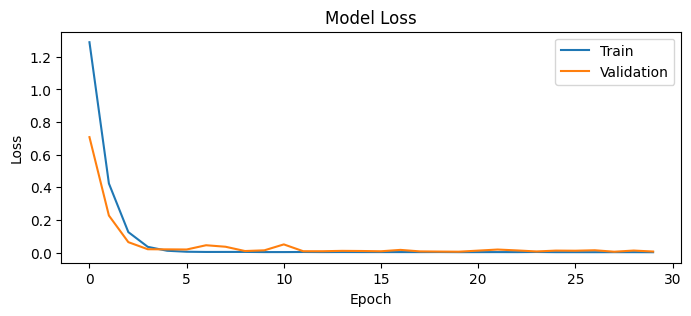

In [202]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_loss_curves(history)

The training and validation loss plot shows a perfect downward curve followed by a flat plaetau for both train and validation loss. This implies our model is balancing well between understanding hidden trends in the data and overfitting to the training data. In terms of bias-variance, the current model should be able to reliably find a minimum between both values.

In [203]:
# Evaluating performance on separate dataset

y_pred = gru.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

25/25 [==============================] - 2s 24ms/step


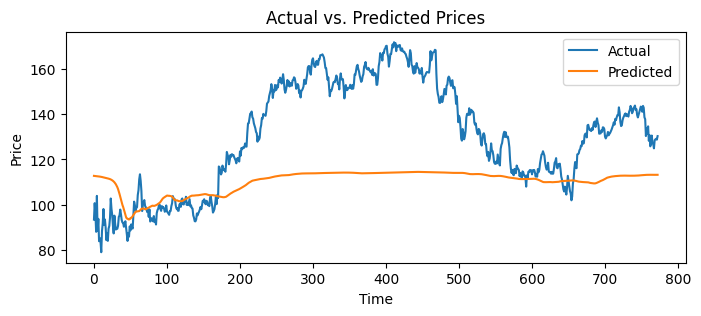

In [204]:
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(8,3))
    plt.plot(y_actual)
    plt.plot(y_predicted)
    plt.title(title)
    plt.ylabel('Price')
    plt.xlabel('Time')
    plt.legend(['Actual', 'Predicted'], loc='upper right')
    plt.show()

# Plot actual vs. predicted prices for the training and validation sets
plot_actual_vs_predicted(y_test, y_pred, 'Actual vs. Predicted Prices')

As we can clearly observe, our prediction is heavily deviated from the true values. It seems that the predicted trend follows the general direction of the actual trend but exhibits milder fluctuations than the actual trend. This suggest that my predictions captures the overal movement of the actual trend, but not the intensity.

In [205]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_error(y_test, y_pred)/np.mean(y_test)*100
explained_variance = explained_variance_score(y_test, y_pred)

print(f"R2 Score: {r2}")
print(f"Root mean squared error: {rmse}")
print(f"Mean absolute percentage error: {mape}")
print(f"Explained variance percentage: {explained_variance}")

R2 Score: -0.43717358301196607
Root mean squared error: 28.820889345907133
Mean absolute percentage error: 17.991570059630707
Explained variance percentage: 0.26528491149311906


The metrics above simply reinforces the poor performance of the current model, as it suggests the current model cannot capture trends in current data, nor can it rationalize movement in unseen data.

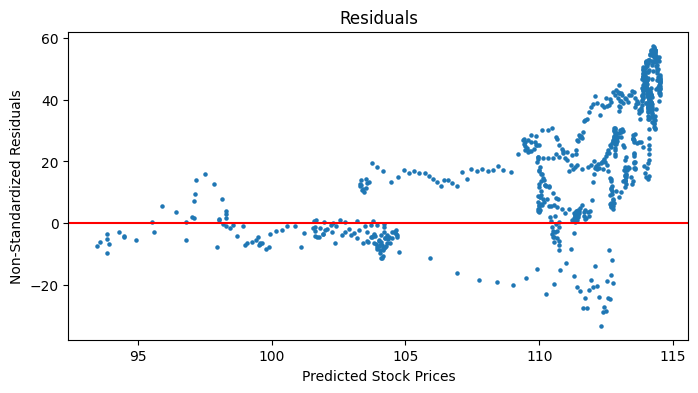

In [206]:
# Plotting residuals to understand distribution of errors

residuals = y_test.flatten() - y_pred.flatten()

plt.figure(figsize=(8,4))
plt.scatter(y_pred.flatten(), residuals, s=5)
plt.axhline(y=0, color='r')
plt.xlabel('Predicted Stock Prices')
plt.ylabel('Non-Standardized Residuals')
plt.title('Residuals')
plt.show()

It is clear that our residuals are not independent or normally distributed, but rather denser away from the origin and skewed toward higher values. This suggests systematic bias, combined with the accuracy plot above, we can now confirm that the model consistently under-estimates the prices. Furthermore, the denser distribution of residuals as the skew increases indicates heteroscedasticity, which implies the model may not perform as well on extreme values.

### Improving model performance

We conclude from the peformance diagnostics that our model suffers from not understanding the intensity of change across the data. Given the prescence of heteroscedasticity, we can further speculate that the cause of this confusion is from not learning from drastic changes, making the model think that only mild changes are required. Therefore, the remedy is to let the model focus on the drastic changes separately from the rest of the input using attention mechanisms.

In [207]:
# Define the attention mechanism layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")        
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b), axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [208]:
# GRU model with attention mechanism

def gru_attention_model(input_shape):
    model = Sequential()

    # Add a TimeDistributed layer on top of the input layer
    model.add(layers.TimeDistributed(layers.Dense(6), input_shape=input_shape))

    # GRU layers for learning, return_sequences=True for stacking layers and attention mechanism
    model.add(layers.GRU(60, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.GRU(40, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.GRU(30, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.GRU(60, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))

    model.add(layers.Dropout(0.3))

    # Add attention layer
    model.add(AttentionLayer())

    # Dense layers to output prediction
    model.add(layers.Dense(units=1))

    return model

### New Model Training

In [209]:
gru_attention = gru_attention_model(X_train.shape[1:])
gru_attention.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

In [210]:
# Define callbacks
checkpointer_attention = ModelCheckpoint(
    filepath = 'best_weights_attention.hdf5', 
    verbose = 2, 
    save_best_only = True
)

# Define learning rate scheduler to achieve faster convergence
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(lr_schedule)

history_attention = gru_attention.fit(
    X_train, 
    y_train, 
    epochs = 30, 
    batch_size = 32,
    callbacks = [checkpointer_attention, lr_scheduler],
    validation_data = [X_val, y_val]
)

Epoch 1/30
62/62 [==============================] - ETA: 0s - loss: 1.2860
Epoch 1: val_loss improved from inf to 0.71459, saving model to best_weights_attention.hdf5
62/62 [==============================] - 16s 118ms/step - loss: 1.2860 - val_loss: 0.7146 - lr: 0.0010
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.4271
Epoch 2: val_loss improved from 0.71459 to 0.22239, saving model to best_weights_attention.hdf5
62/62 [==============================] - 5s 84ms/step - loss: 0.4271 - val_loss: 0.2224 - lr: 0.0010
Epoch 3/30
62/62 [==============================] - ETA: 0s - loss: 0.1273
Epoch 3: val_loss improved from 0.22239 to 0.06701, saving model to best_weights_attention.hdf5
62/62 [==============================] - 5s 77ms/step - loss: 0.1273 - val_loss: 0.0670 - lr: 0.0010
Epoch 4/30
62/62 [==============================] - ETA: 0s - loss: 0.0377
Epoch 4: val_loss improved from 0.06701 to 0.03857, saving model to best_weights_attention.hdf5
62/62 [========

### New Model Evaluation

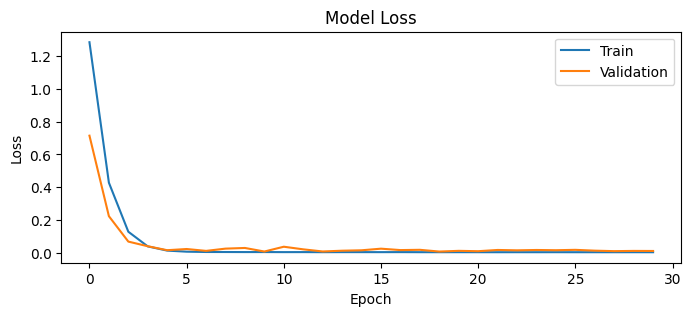

In [211]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_loss_curves(history_attention)

Similar to the basic model, our training and validation losses seems to be in an appropriate shape, indicating no significant under or over-fitting.

In [212]:
# Evaluating performance on separate dataset

y_pred_attention = gru_attention.predict(X_test)
y_pred_attention = scaler_y.inverse_transform(y_pred_attention)

25/25 [==============================] - 2s 19ms/step


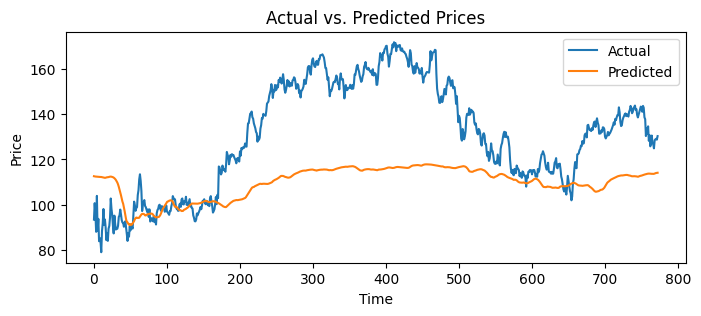

In [213]:
plot_actual_vs_predicted(y_test, y_pred_attention, 'Actual vs. Predicted Prices')

In [214]:
r2_attention = r2_score(y_test, y_pred_attention)
rmse_attention = np.sqrt(mean_squared_error(y_test, y_pred_attention))
mape_attention = mean_absolute_error(y_test, y_pred_attention)/np.mean(y_test)*100
explained_variance_attention = explained_variance_score(y_test, y_pred_attention)

print(f"R2 Score: {r2_attention}")
print(f"Root mean squared error: {rmse_attention}")
print(f"Mean absolute percentage error: {mape_attention}")
print(f"Explained variance percentage: {explained_variance_attention}")

R2 Score: -0.38696516382745716
Root mean squared error: 28.31297736091561
Mean absolute percentage error: 17.848767024149165
Explained variance percentage: 0.35155049583076425


From the evaluation metrics above, we can see that the performance of this new model is slightly better than the basic model. According to domain experts, the features (stock market indices) have varying levels of importance, particularly 'Volume', which greatly influences the trend of a stock. However, since Gated Recurrent Unit models cannot incorporate relative importance of features during training, we will have to either attempt feature engineering, or ensemble methods, both of which would be computationally expensive on my home laptop. Therefore, we will leave further implementations to separate projects.

### References

Scikit-learn article

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html